In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import ticker


In [2]:
PER_EPOCH_FNAME = "./outputs/per_epoch_for_d3.csv"
POSTPROCESS_FNAME = "./outputs/postprocess_for_d3.csv"

per_epoch_df = pd.read_csv(PER_EPOCH_FNAME, header=0, index_col=False)
postprocess_df = pd.read_csv(POSTPROCESS_FNAME, header=0, index_col=False)

METRIC_COLNAMES = [
    "average_local_error",
    "class_aware_continuity",
    "class_aware_trustworthiness",
    "continuity",
    "distance_consistency",
    "false_neighbors",
    "jaccard",
    "mrre_data",
    "mrre_proj",
    "neighborhood_hit",
    "normalized_stress",
    "pearson_correlation",
    "procrustes",
    "scale_normalized_stress",
    "shepard_goodness",
    "true_neighbors",
    "trustworthiness",
]

In [3]:
def _id(x):
    return x


def _flip(x):
    return 1 - x

def _negate(x):
    return -x

def _shift_scale(shift:float, scale: float):
    return lambda x: scale * (x - shift)

def _shift(by:float):
    return _shift_scale(by, 1.0)

def _flip_shift(by:float):
    return lambda x: by - x


adapters = {k: _id for k in per_epoch_df.columns}
adapters |=  {
    "average_local_error": _id,
    "class_aware_continuity": _flip,
    "class_aware_trustworthiness": _flip,
    "continuity": _flip,
    "distance_consistency": _flip,
    "false_neighbors": _id,
    "jaccard": _flip,
    "mrre_data": _id,
    "mrre_proj":_id,
    "neighborhood_hit": _flip,
    "normalized_stress": _id,
    "pearson_correlation": lambda x: _flip((1+x)/2),
    "procrustes": _id,
    "scale_normalized_stress": _id,
    "shepard_goodness": lambda x: _flip((1+x)/2),
    "true_neighbors": _flip,
    "trustworthiness": _flip,
}

In [4]:
## ALTERNATIVE ADAPTERS FOR "BIGGER IS BETTER" ENCODING
from typing import Callable, Mapping


metric_adapters: Mapping[str, Callable[[float], float]] = {
    "average_local_error": _negate,
    "class_aware_continuity": _id,
    "class_aware_trustworthiness": _id,
    "continuity": _id,
    "distance_consistency": _id,
    "false_neighbors": _negate,
    "jaccard": _id,
    "mrre_data": _negate,
    "mrre_proj": _negate,
    "neighborhood_hit": _id,
    "normalized_stress": _negate,
    "pearson_correlation": _shift_scale(1, 0.5),
    "procrustes": _negate,
    "scale_normalized_stress": _negate,
    "shepard_goodness": _shift_scale(1, 0.5),
    "true_neighbors": _id,
    "trustworthiness": _id,

}
adapters |= metric_adapters

In [5]:
def calc_diffs(df: pd.DataFrame) -> pd.DataFrame:
    df_c = df.copy()
    metric_vals = df_c[METRIC_COLNAMES]
    assert len(df_c[df_c.epoch == -1]) == 1, f"{len(df_c[df_c.epoch == -1]) = }\n{df_c}"
    diffs = metric_vals - df_c[df_c.epoch == -1][METRIC_COLNAMES].iloc[0]
    df_c[METRIC_COLNAMES] = diffs
    return df_c


In [6]:
adapted_per_epoch_df = per_epoch_df.transform(adapters)

In [7]:
per_epoch_diffs = per_epoch_df.groupby(by=['dataset', 'projection', 'metric', 'k']).apply(calc_diffs, include_groups=False)
per_epoch_diffs = per_epoch_diffs.reset_index()
per_epoch_diffs_raw = per_epoch_diffs.copy()
per_epoch_diffs = per_epoch_diffs[per_epoch_diffs.epoch == 1000]
adapted_diff_df = adapted_per_epoch_df.groupby(by=['dataset', 'projection', 'metric', 'k']).apply(calc_diffs, include_groups=False)
adapted_diff_df = adapted_diff_df.reset_index()
adapted_diff_df = adapted_diff_df[adapted_diff_df.epoch == 1000]


In [8]:
NICE_METRIC_NAMES = {
    "average_local_error": "Avg. Local Error",
    "class_aware_continuity": "Class-Aware Cont.",
    "class_aware_trustworthiness": "Class-Aware Trustw.",
    "continuity": "Continuity",
    "distance_consistency": "Dist. Consistency",
    "false_neighbors": "False Neighbors",
    "jaccard": "Jaccard",
    # "//" "missing_neighbors",
    "mrre_data": "MRRE Data",
    "mrre_proj": "MRRE Projection",
    "neighborhood_hit": "Neighborhood Hit",
    "normalized_stress": "Normalized Stress",
    "pearson_correlation": "Pearson R",
    "procrustes": "Procrustes",
    "scale_normalized_stress": "Scale-Norm. Stress",
    "shepard_goodness": "Shepard Goodness",
    "true_neighbors": "True Neighbors",
    "trustworthiness": "Trustworthiness",
    "all": "ALL",
}

In [9]:
per_epoch_diffs

dataset projection            metric   k  level_4  epoch  \
10    fashionmnist     isomap               all   1     5350   1000   
22    fashionmnist     isomap               all   7     5122   1000   
34    fashionmnist     isomap               all  21     5578   1000   
46    fashionmnist     isomap               all  51     4738   1000   
58    fashionmnist     isomap        continuity   1     2398   1000   
...            ...        ...               ...  ..      ...    ...   
5710          usps       umap  neighborhood_hit  51     4258   1000   
5722          usps       umap   trustworthiness   1     1162   1000   
5734          usps       umap   trustworthiness   7     1918   1000   
5746          usps       umap   trustworthiness  21     1582   1000   
5758          usps       umap   trustworthiness  51     1858   1000   

      average_local_error  class_aware_continuity  \
10                  0.076                   0.001   
22                  0.253                  -0.035   
34                  0.148                   0.000   
46                  0.065                   0.005   
58                  0.120                  -0.001   
...                   ...                     ...   
5710                0.112                  -0.042   
5722                0.098                  -0.038   
5734                0.105                  -0.040   
5746                0.115                  -0.039   
5758                0.114                  -0.039   

      class_aware_trustworthiness  continuity  ...  mrre_data  mrre_proj  \
10                          0.046       0.000  ...     -0.060      0.000   
22                          0.042      -0.056  ...     -0.056      0.053   
34                          0.048      -0.006  ...     -0.059      0.007   
46                          0.047       0.002  ...     -0.061     -0.002   
58                          0.045      -0.003  ...     -0.057      0.003   
...                           ...         ...  ...        ...        ...   
5710                       -0.017      -0.040  ...      0.007      0.040   
5722                       -0.004      -0.040  ...     -0.007      0.040   
5734                       -0.008      -0.040  ...     -0.004      0.039   
5746                       -0.012      -0.041  ...      0.000      0.039   
5758                       -0.031      -0.038  ...      0.011      0.037   

      neighborhood_hit  normalized_stress  pearson_correlation  procrustes  \
10               0.139              0.034               -0.102       0.000   
22               0.116             -0.033               -0.541      -0.036   
34               0.134              0.068               -0.342      -0.015   
46               0.127             -0.007               -0.251      -0.002   
58               0.130              0.050               -0.381       0.000   
...                ...                ...                  ...         ...   
5710            -0.144              0.156               -0.166      -0.036   
5722            -0.070              0.112                0.120       0.000   
5734            -0.102              0.143               -0.110      -0.032   
5746            -0.117              0.093               -0.418      -0.032   
5758            -0.162              0.011               -0.175      -0.033   

      scale_normalized_stress  shepard_goodness  true_neighbors  \
10                      0.050            -0.088           0.050   
22                      0.343            -0.448           0.094   
34                      0.294            -0.205           0.170   
46                      0.116            -0.219           0.202   
58                      0.183            -0.365           0.032   
...                       ...               ...             ...   
5710                    0.225            -0.071          -0.113   
5722                    0.193             0.230          -0.038   
5734                    0.238             0.045          -0.092   
5

In [10]:
sns.set_theme(rc={"axes.facecolor": (0, 0, 0, 0)})


In [11]:
def label(label, *, color=None, **kwargs):
    ax: plt.Axes = plt.gca()
    ax.text(
        0,
        0.1,
        label.iloc[0],
        fontweight="bold",
        color="k",
        ha="left",
        va="center",
        transform=ax.transAxes,
        fontsize=16,
    )


def ticklabel_sizes(*, size, **kwargs):
    from matplotlib import ticker
    ax: plt.Axes = plt.gca()
    plt.setp(ax.get_xticklabels(), fontsize=size)
    # ax.set_xticks([])
    ax.tick_params('x', which='both', bottom=True)
    ax.xaxis.set_major_formatter(ticker.NullFormatter())
    ax.xaxis.set_minor_formatter(ticker.NullFormatter())
    ax.grid(visible=False, which="both", axis="both")


def go_plot():
    # Focus on one experiment only for now, and work with all metrics.
    melted = adapted_diff_df.melt(id_vars=[], value_vars=METRIC_COLNAMES, var_name="metric")
    g = sns.FacetGrid(
        melted,
        row="metric",
        # hue="metric",
        aspect=12,
        height=0.8,
        sharey=True,
        sharex=True,
        xlim=(-0.8, 0.8),
    )
    # g.set(autoscalex_on=False)
    g.tick_params("x", which="both", labelsize=24)
    g.map(sns.kdeplot, "value", fill=True, alpha=0.8, clip_on=True, bw_adjust=1)
    g.map(sns.kdeplot, "value", bw_adjust=1, clip_on=True, color="w", lw=2)
    g.refline(y=0, color=None, lw=2, linestyle="-")
    g.refline(x=0, color="r", lw=2, linestyle="--")
    xticks = g.axes.flat[-1].get_xticks()
    g.map(ticklabel_sizes, size=16)
    g.map(label, "metric")
    g.figure.subplots_adjust(hspace=-0.65)
    g.set(yticks=[], ylabel="", xlabel="")
    g.set_titles("")
    # g.set(xlim=(-1.3, 1.3), autoscalex_on=True)
    # g.
    g.despine(bottom=True, left=True)

    g.axes.flat[-1].set_xticks(xticks)
    return g





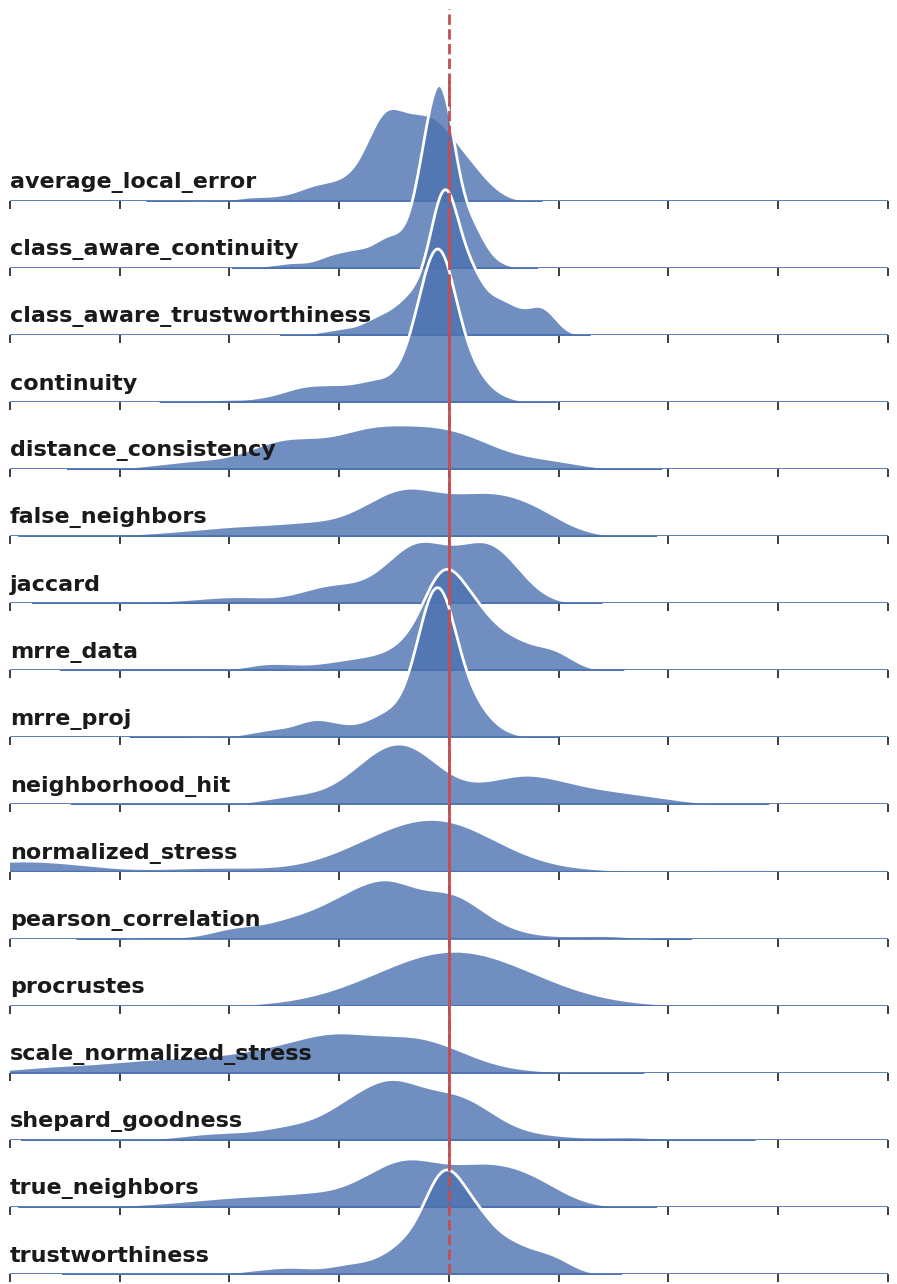

In [12]:
go_plot()

In [13]:
def get_facetgrid_data(data: pd.DataFrame, by: str):
    data_for_facetgrid = data.rename(columns=lambda c: NICE_METRIC_NAMES.get(c, c)).melt(
        id_vars=[by],
        value_vars=[NICE_METRIC_NAMES[m] for m in METRIC_COLNAMES],
        var_name="metricname",
    )
    return data_for_facetgrid

In [14]:
bymetric_facetgrid_data = get_facetgrid_data(adapted_diff_df, by='metric')
sns.set_theme(context="paper", style="whitegrid", rc={"axes.facecolor": (0, 0, 0, 0)}, font_scale=2.0)


In [15]:
import gc

gc.collect()

98

In [16]:
def style_facetgrid(g: sns.FacetGrid, xlabel_ticksize=24, rowname_fontsize=30) -> sns.FacetGrid:
    g.tick_params("x", which="both", labelsize=xlabel_ticksize)
    xticks = list(g.axes.flat[-1].get_xticks())
    g.map(ticklabel_sizes, size=xlabel_ticksize)
    g.figure.subplots_adjust(hspace=-0.65, wspace=0.1)
    g.set(yticks=[], ylabel="", xlabel="")
    g.set_titles("")
    g.despine(left=True, right=True, top=True, bottom=False, offset={"left": 10, "right": 10})
    for ax, row_name in zip(g.axes[:, 0], g.row_names):
        ax.annotate(
            row_name,
            xy=(-0.1, 0.0),
            xycoords="axes fraction",
            rotation=0.0,
            va="baseline",
            ha="right",
            fontsize=rowname_fontsize,
        )
    ax_ = g.axes.flat[-1]
    ax_.set_xticks(xticks[1:-1])
    ax_.xaxis.set_major_formatter(ticker.ScalarFormatter())
    ax_.xaxis.set_minor_formatter(ticker.ScalarFormatter())

    return g

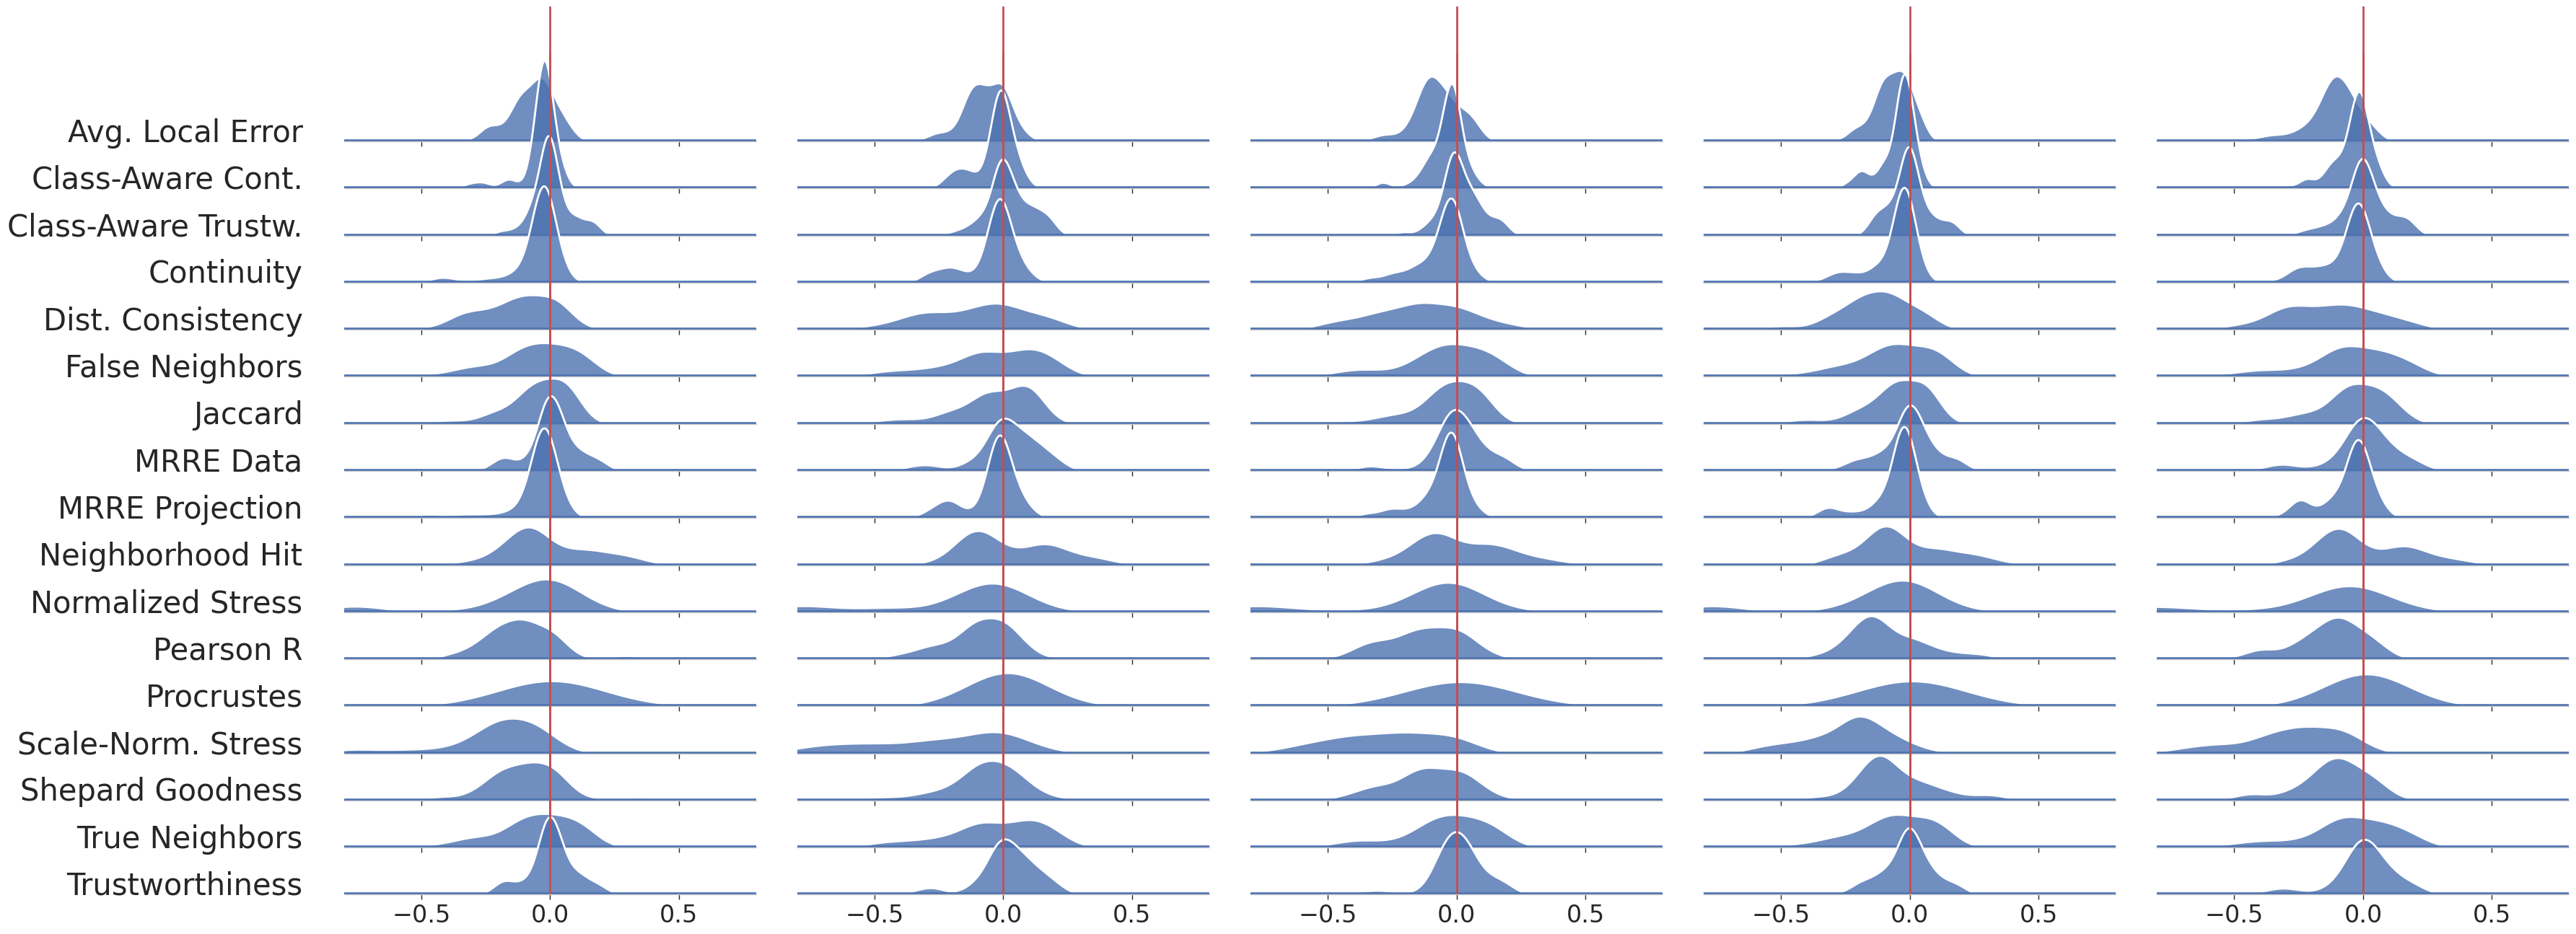

In [17]:
from matplotlib import ticker

g = sns.FacetGrid(
    bymetric_facetgrid_data,
    col="metric",
    col_order=["continuity", "jaccard", "neighborhood_hit", "trustworthiness", "all"],
    row="metricname",
    aspect=8,
    height=0.8,
    sharey=True,
    sharex=True,
    xlim=(-0.8, 0.8),
    despine=True,
)
g.map(sns.kdeplot, "value", fill=True, alpha=0.8, clip_on=True, bw_adjust=1, edgecolor="w", lw=2)
g.refline(y=0, color=None, lw=4, linestyle="-", alpha=1.0)
g.refline(x=0, color="r", alpha=1.0, lw=2, linestyle="-", clip_on=True)
g = style_facetgrid(g)


In [18]:

HIGHLIGHT_COLOR = "#0000FF"
def highlight_per_metric_target(g: sns.FacetGrid) -> sns.FacetGrid:
    g.axes_dict[('Trustworthiness', 'trustworthiness')].get_children()[0].set_facecolor(HIGHLIGHT_COLOR)
    g.axes_dict[('Continuity', 'continuity')].get_children()[0].set_facecolor(HIGHLIGHT_COLOR)
    g.axes_dict[('Neighborhood Hit', 'neighborhood_hit')].get_children()[0].set_facecolor(HIGHLIGHT_COLOR)
    g.axes_dict[('Jaccard', 'jaccard')].get_children()[0].set_facecolor(HIGHLIGHT_COLOR)
    g.axes_dict[('Trustworthiness', 'all')].get_children()[0].set_facecolor(HIGHLIGHT_COLOR)
    g.axes_dict[('Continuity', 'all')].get_children()[0].set_facecolor(HIGHLIGHT_COLOR)
    g.axes_dict[('Neighborhood Hit', 'all')].get_children()[0].set_facecolor(HIGHLIGHT_COLOR)
    g.axes_dict[('Jaccard', 'all')].get_children()[0].set_facecolor(HIGHLIGHT_COLOR)
    return g

g = highlight_per_metric_target(g)

array([38.4, 13.6])

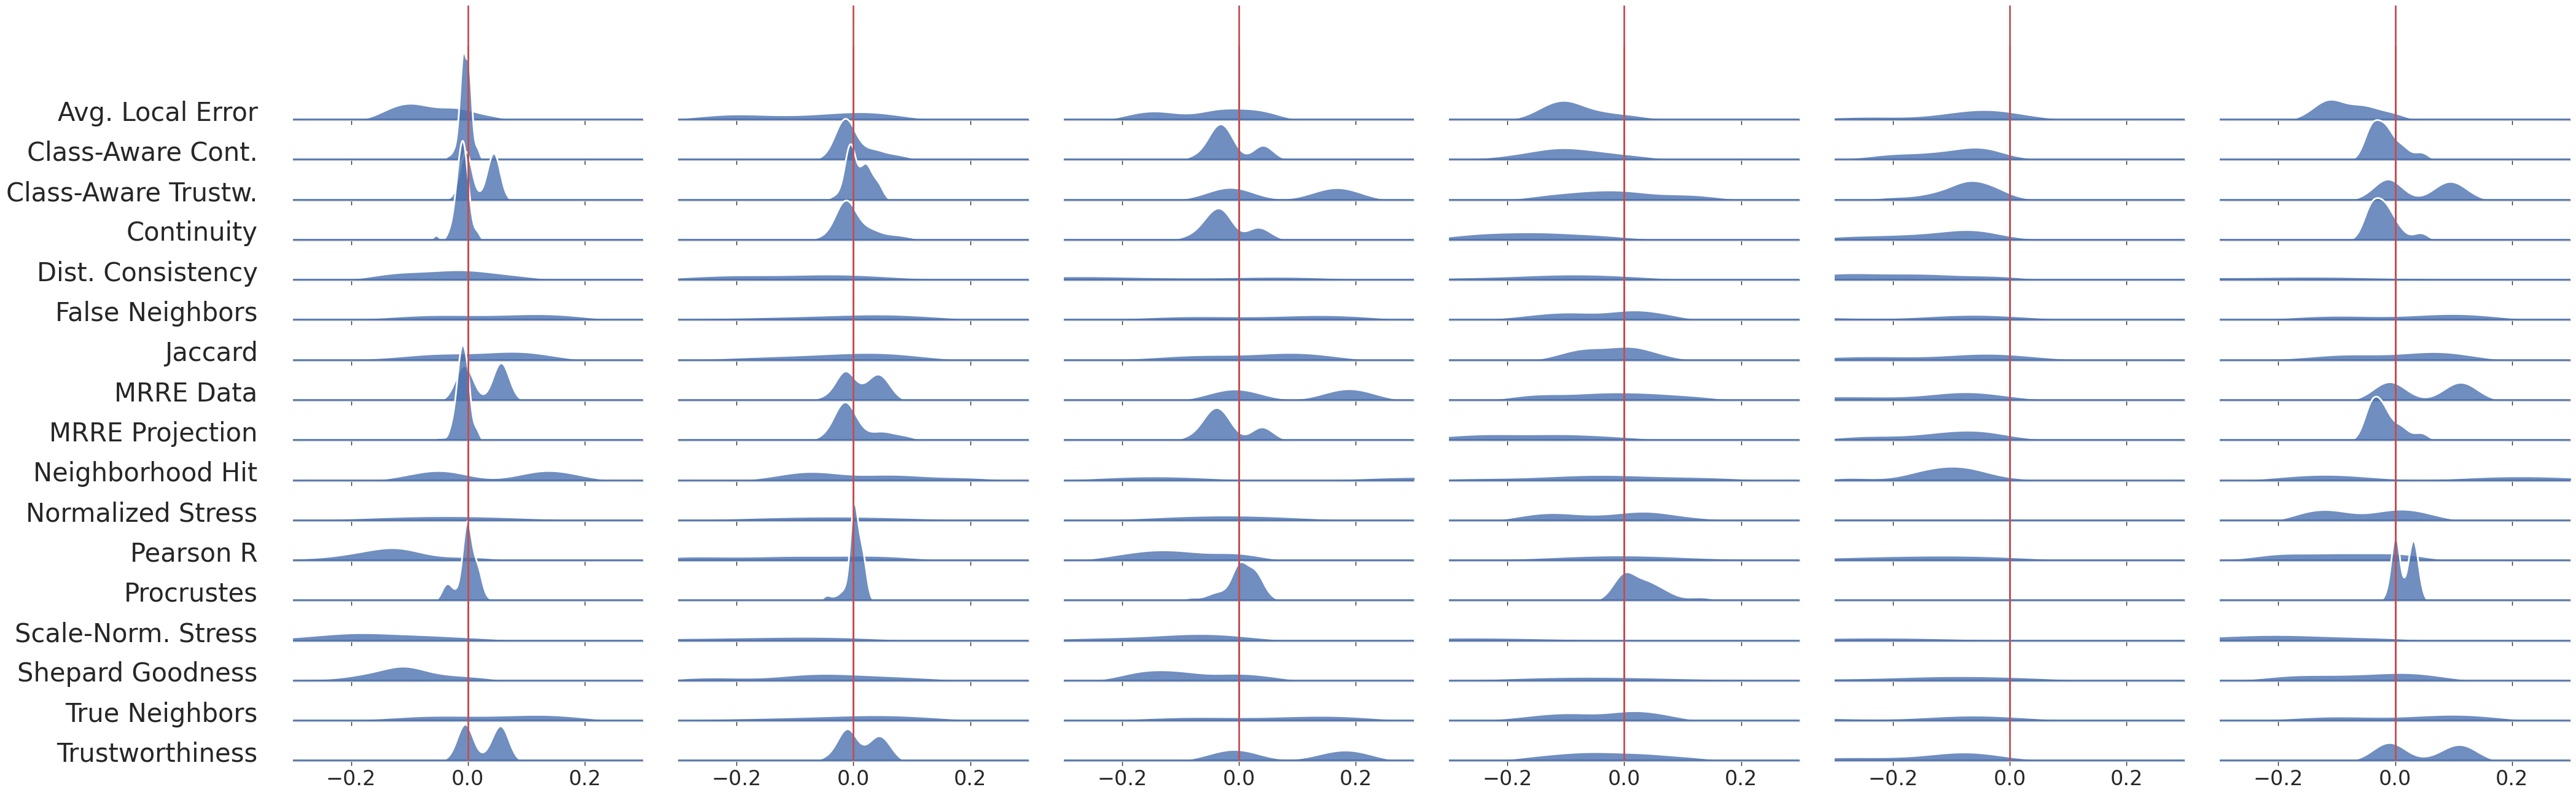

In [19]:
g = sns.FacetGrid(
    get_facetgrid_data(adapted_diff_df, by='dataset'),
    col="dataset",
    col_order=["fashionmnist", "har", "mnist", "reuters", "spambase", "usps"],
    row="metricname",
    aspect=8,
    height=0.8,
    sharey=True,
    sharex=True,
    xlim=(-0.3, 0.3),
    despine=True,
)
g.map(sns.kdeplot, "value", fill=True, alpha=0.8, clip_on=True, bw_adjust=1, edgecolor="w", lw=2)
g.refline(y=0, color=None, lw=4, linestyle="-", alpha=1.0)
g.refline(x=0, color="r", alpha=1.0, lw=2, linestyle="-", clip_on=True)
g = style_facetgrid(g)
g.figure.get_size_inches()

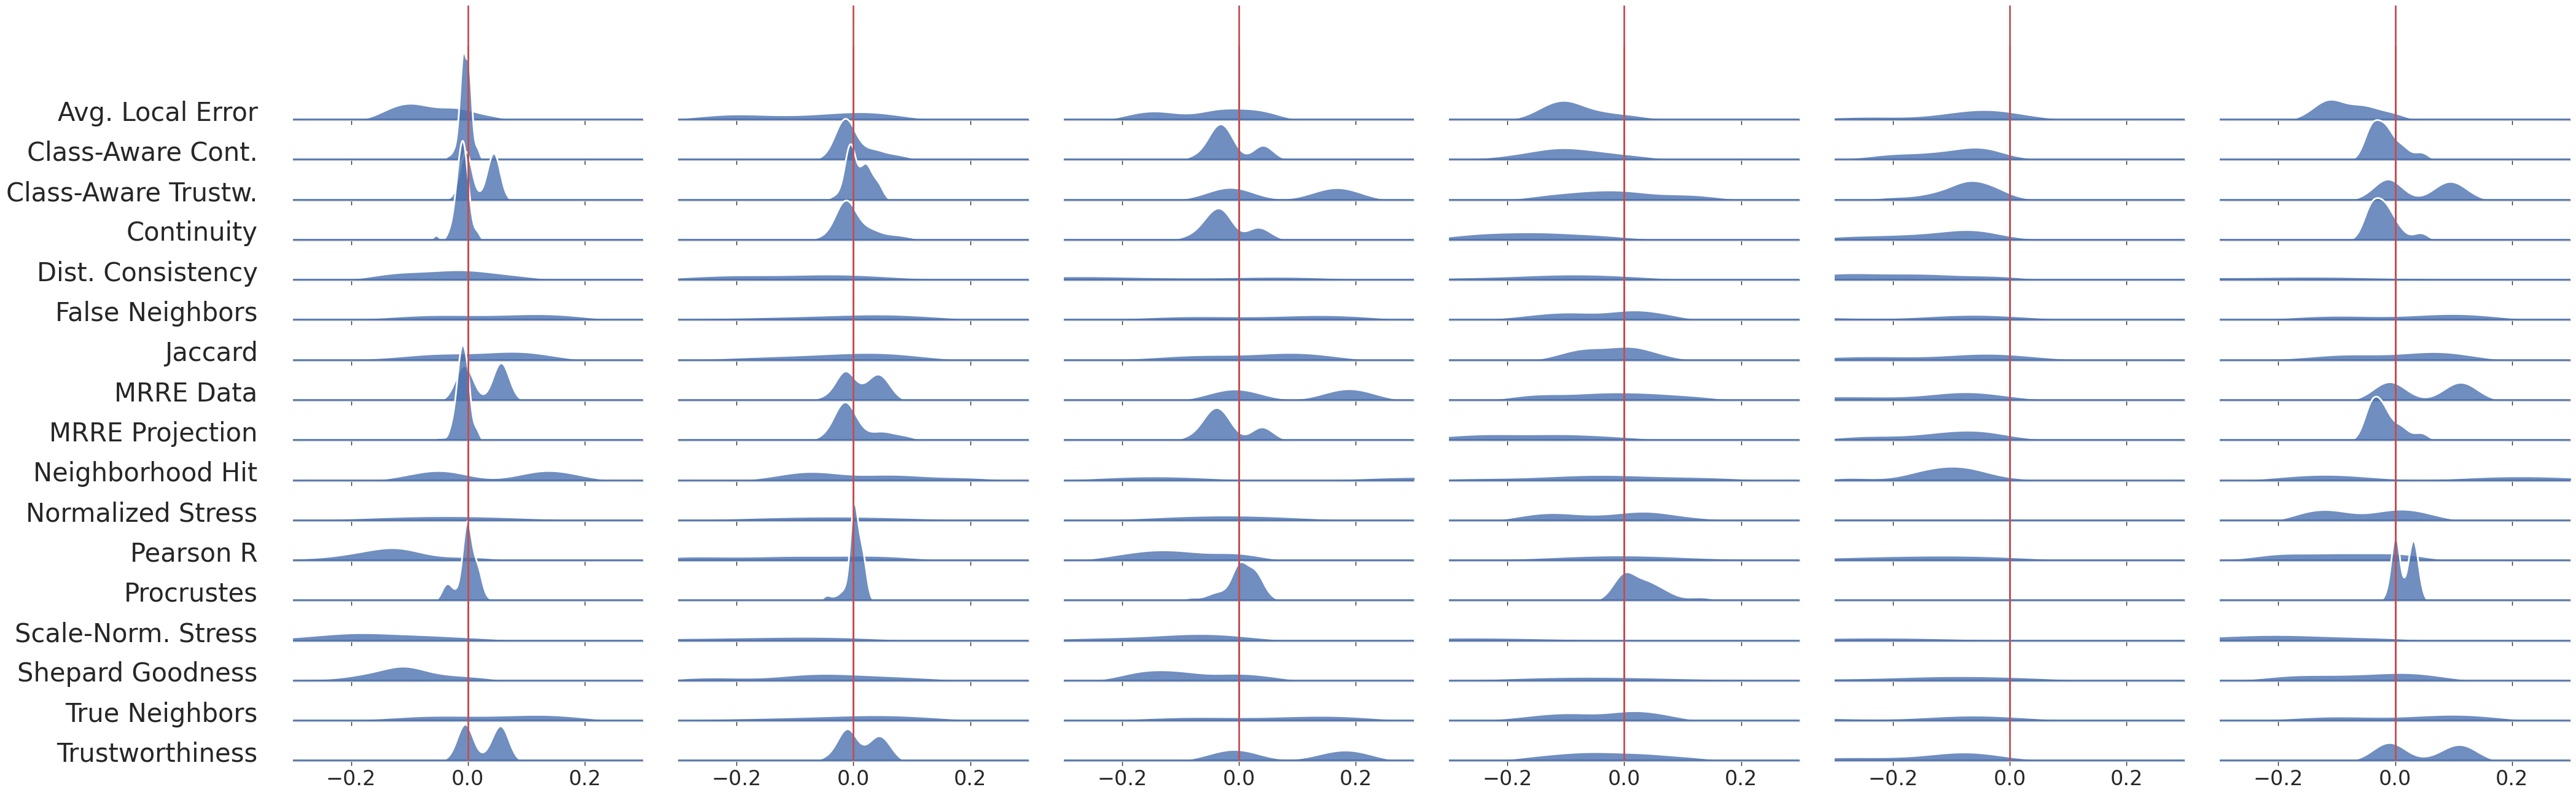

In [20]:
g.figure

In [ ]:
plt.rcParams.update(
    {
        "savefig.dpi": 256,
        "savefig.bbox": "tight",
        "savefig.pad_inches": 0.2,
        "lines.markersize": 2.0,
    }
)

g.figure.savefig("./outputs/ReplacementCandidateForBoxPlots_HigherIsBetter.pdf")

In [22]:
byprojection_facetgrid_data = get_facetgrid_data(adapted_diff_df[adapted_diff_df.k==51], by='projection')


In [23]:
byprojection_facetgrid_data

projection        metricname  value
0        isomap  Avg. Local Error -0.065
1        isomap  Avg. Local Error -0.094
2        isomap  Avg. Local Error -0.139
3        isomap  Avg. Local Error -0.126
4        isomap  Avg. Local Error -0.113
...         ...               ...    ...
2035       umap   Trustworthiness -0.008
2036       umap   Trustworthiness -0.029
2037       umap   Trustworthiness -0.012
2038       umap   Trustworthiness -0.010
2039       umap   Trustworthiness -0.026

[2040 rows x 3 columns]

In [24]:
gc.collect()

164938

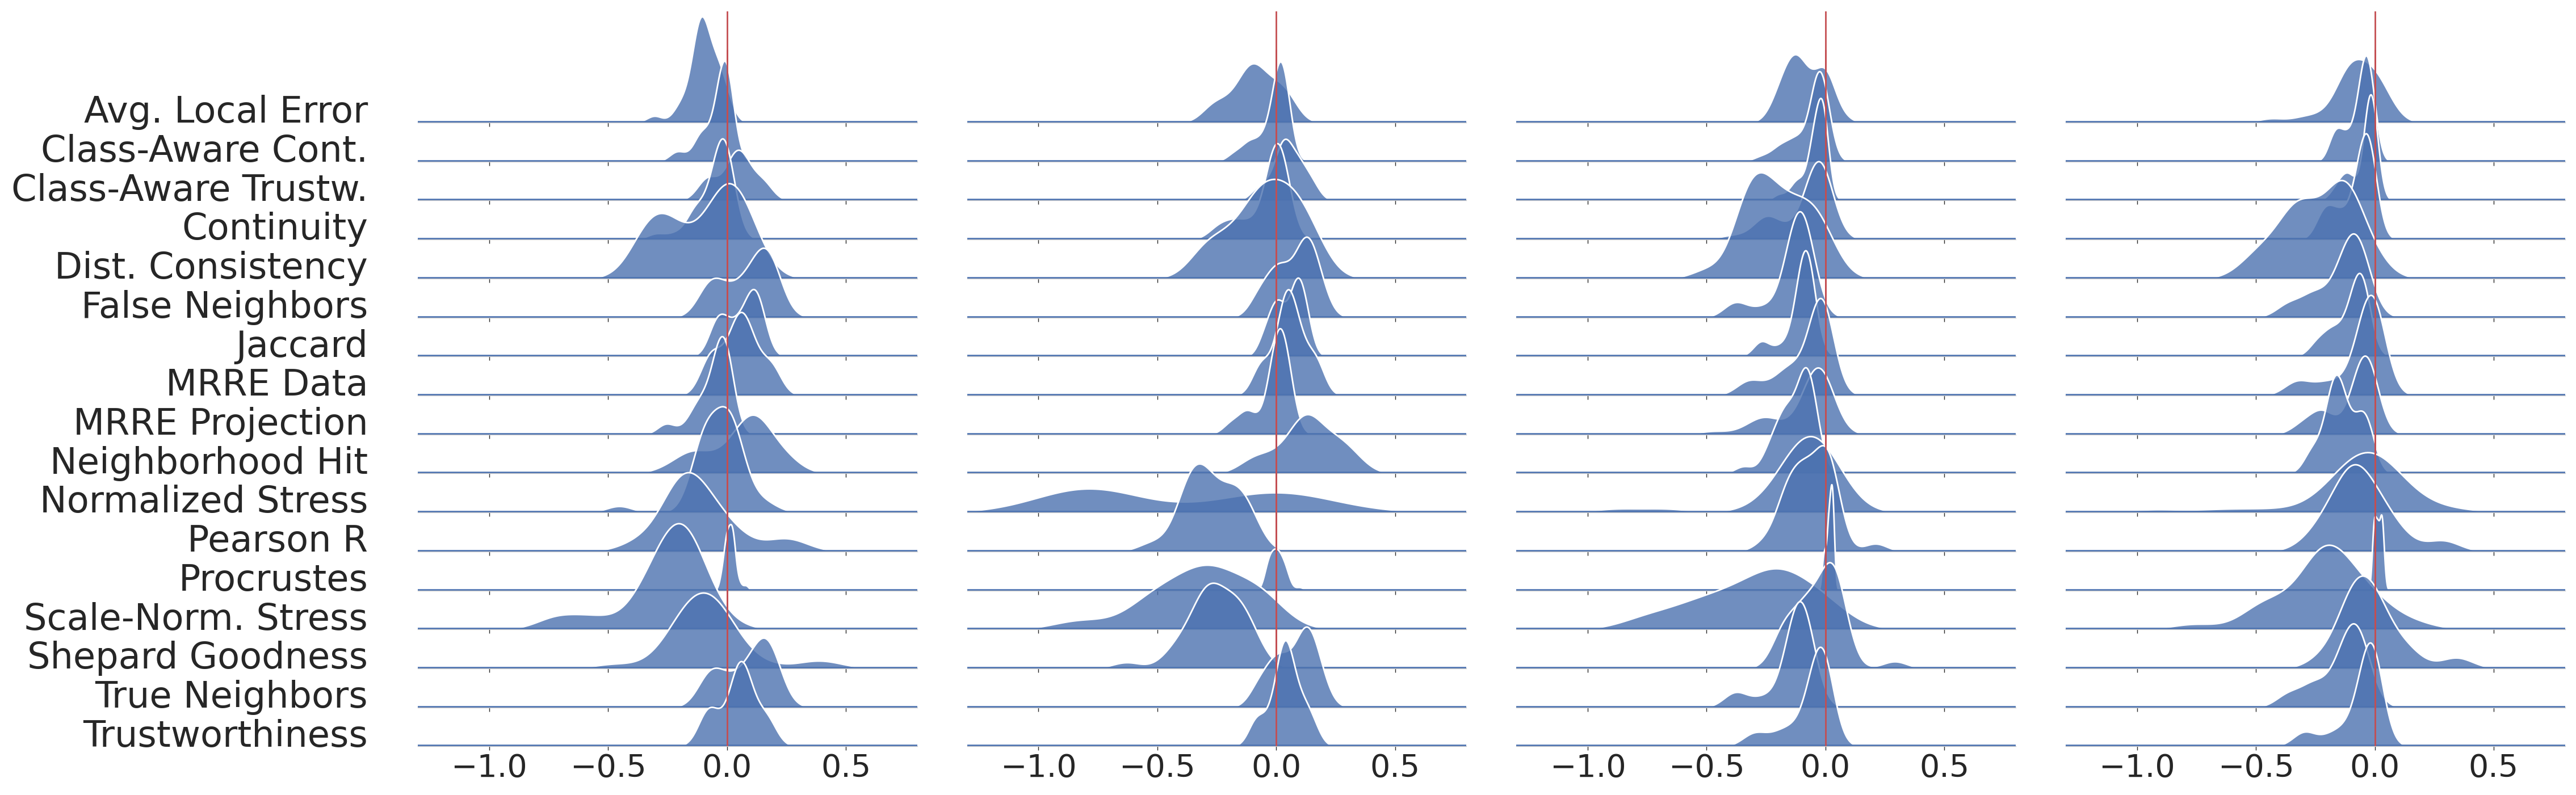

In [25]:
sns.set_theme(context="paper", style="whitegrid", rc={"axes.facecolor": (0, 0, 0, 0)}, font_scale=2.0)
# array([38.4, 13.6])
g = sns.FacetGrid(
    byprojection_facetgrid_data,
    col="projection",
    col_order=["isomap", "mds", "tsne", "umap"],
    row="metricname",
    aspect=3.0,
    height=0.8,
    sharey="row",
    sharex=True,
    xlim=(-1.3, 0.8),
    despine=True,
)
g.map(sns.kdeplot,"value", fill=True, alpha=0.8, clip_on=True, bw_adjust=1, edgecolor="w", lw=2)
g.set(yticks=[], ylabel="", xlabel="")
g.set_titles("")
g.figure.set_figwidth(38.4)
g.refline(y=0, color=None, lw=4, linestyle="-", alpha=1.0)
g.refline(x=0, color="r", alpha=1.0, lw=2, linestyle="-", clip_on=True)
g = style_facetgrid(g, xlabel_ticksize=40, rowname_fontsize=46)
# g.axes.flat[-1].set_xticks(g.axes.flat[-1].get_xticks()[1::2])

In [ ]:
plt.rcParams.update(
    {
        "savefig.dpi": 256,
        "savefig.bbox": "tight",
        "savefig.pad_inches": 0.2,
        "lines.markersize": 2.0,
    }
)
g.figure.savefig("./outputs/RidgelinesPlotMetricDiffGroupedByProjectionv2_HigherIsBetter.pdf")

In [27]:
bymetric_facetgrid_data = get_facetgrid_data(adapted_diff_df, by='metric')
bymetric_facetgrid_data

metric        metricname  value
0                  all  Avg. Local Error -0.076
1                  all  Avg. Local Error -0.253
2                  all  Avg. Local Error -0.148
3                  all  Avg. Local Error -0.065
4           continuity  Avg. Local Error -0.120
...                ...               ...    ...
8155  neighborhood_hit   Trustworthiness -0.010
8156   trustworthiness   Trustworthiness  0.007
8157   trustworthiness   Trustworthiness  0.003
8158   trustworthiness   Trustworthiness -0.005
8159   trustworthiness   Trustworthiness -0.026

[8160 rows x 3 columns]

In [52]:
pre_and_post_fooling = adapted_per_epoch_df[adapted_per_epoch_df.epoch.isin((-1, 1000))].copy()
pre_and_post_fooling.loc[:, 'Kind'] = 'Pre-Fooling'
pre_and_post_fooling.loc[per_epoch_diffs_raw.epoch == 1000, 'Kind'] = 'Post-Fooling'
pre_and_post_fooling

epoch  average_local_error  class_aware_continuity  \
10     1000               -0.078                   0.978   
11       -1               -0.159                   0.991   
22     1000               -0.100                   0.701   
23       -1               -0.025                   0.884   
34     1000               -0.287                   0.951   
...     ...                  ...                     ...   
5735     -1               -0.134                   0.956   
5746   1000               -0.406                   0.945   
5747     -1               -0.034                   0.893   
5758   1000               -0.362                   0.873   
5759     -1               -0.270                   0.821   

      class_aware_trustworthiness  continuity  distance_consistency  \
10                          0.994       0.974                 0.698   
11                          0.994       0.988                 0.696   
22                          0.815       0.600                 0.483   
23                          0.901       0.852                 0.782   
34                          0.976       0.921                 0.662   
...                           ...         ...                   ...   
5735                        0.980       0.938                 0.790   
5746                        0.987       0.938                 0.448   
5747                        0.947       0.887                 0.551   
5758                        0.861       0.681                 0.626   
5759                        0.705       0.728                 0.448   

      false_neighbors  jaccard  missing_neighbors  mrre_data  ...  procrustes  \
10             -0.760    0.154              0.760     -0.019  ...      -0.994   
11             -0.686    0.209              0.686     -0.021  ...      -0.999   
22             -0.906    0.068              0.906     -0.350  ...      -0.900   
23             -0.824    0.116              0.824     -0.285  ...      -0.998   
34             -0.626    0.240              0.626     -0.038  ...      -0.955   
...               ...      ...                ...        ...  ...         ...   
5735           -0.503    0.367              0.503     -0.044  ...      -0.970   
5746           -0.844    0.097              0.844     -0.039  ...      -0.974   
5747           -0.943    0.033              0.943     -0.089  ...      -0.943   
5758           -0.914    0.086              0.914     -0.309  ...      -0.000   
5759           -0.988    0.012              0.988     -0.441  ...      -0.000   

      scale_normalized_stress  shepard_goodness  true_neighbors  \
10                     -0.091           -0.1180           0.240   
11                     -0.161           -0.2325           0.314   
22                     -0.931           -0.6895           0.094   
23                     -0.069           -0.0605           0.176   
34                     -0.720           -0.2210           0.374   
...                       ...               ...             ...   
5735                   -0.241           -0.3030           0.497   
5746                   -0.364           -0.1110           0.156   
5747                   -0.038           -0.0290           0.057   
5758                   -0.424           -0.6490           0.086   
5759                   -0.144           -0.2325           0.012   

      trustworthiness  projection   dataset   k   metric          Kind  
10              0.981        umap       har   7  jaccard  Post-Fooling  
11              0.978        umap       har   7  jaccard   Pre-Fooling  
22              0.612         mds  spambase  51  jaccard  Post-Fooling  
23              0.705         mds  spambase  51  jaccard   Pre-Fooling  
34              0.953        tsne      usps  51  jaccard  Post-Fooling  
...               ...         ...       ...  ..      ...           ...  
5735            0.923        tsne  spambase  21      all   Pre-Fooling  
5746            0.961         mds       har   7      all  Post-Fooling

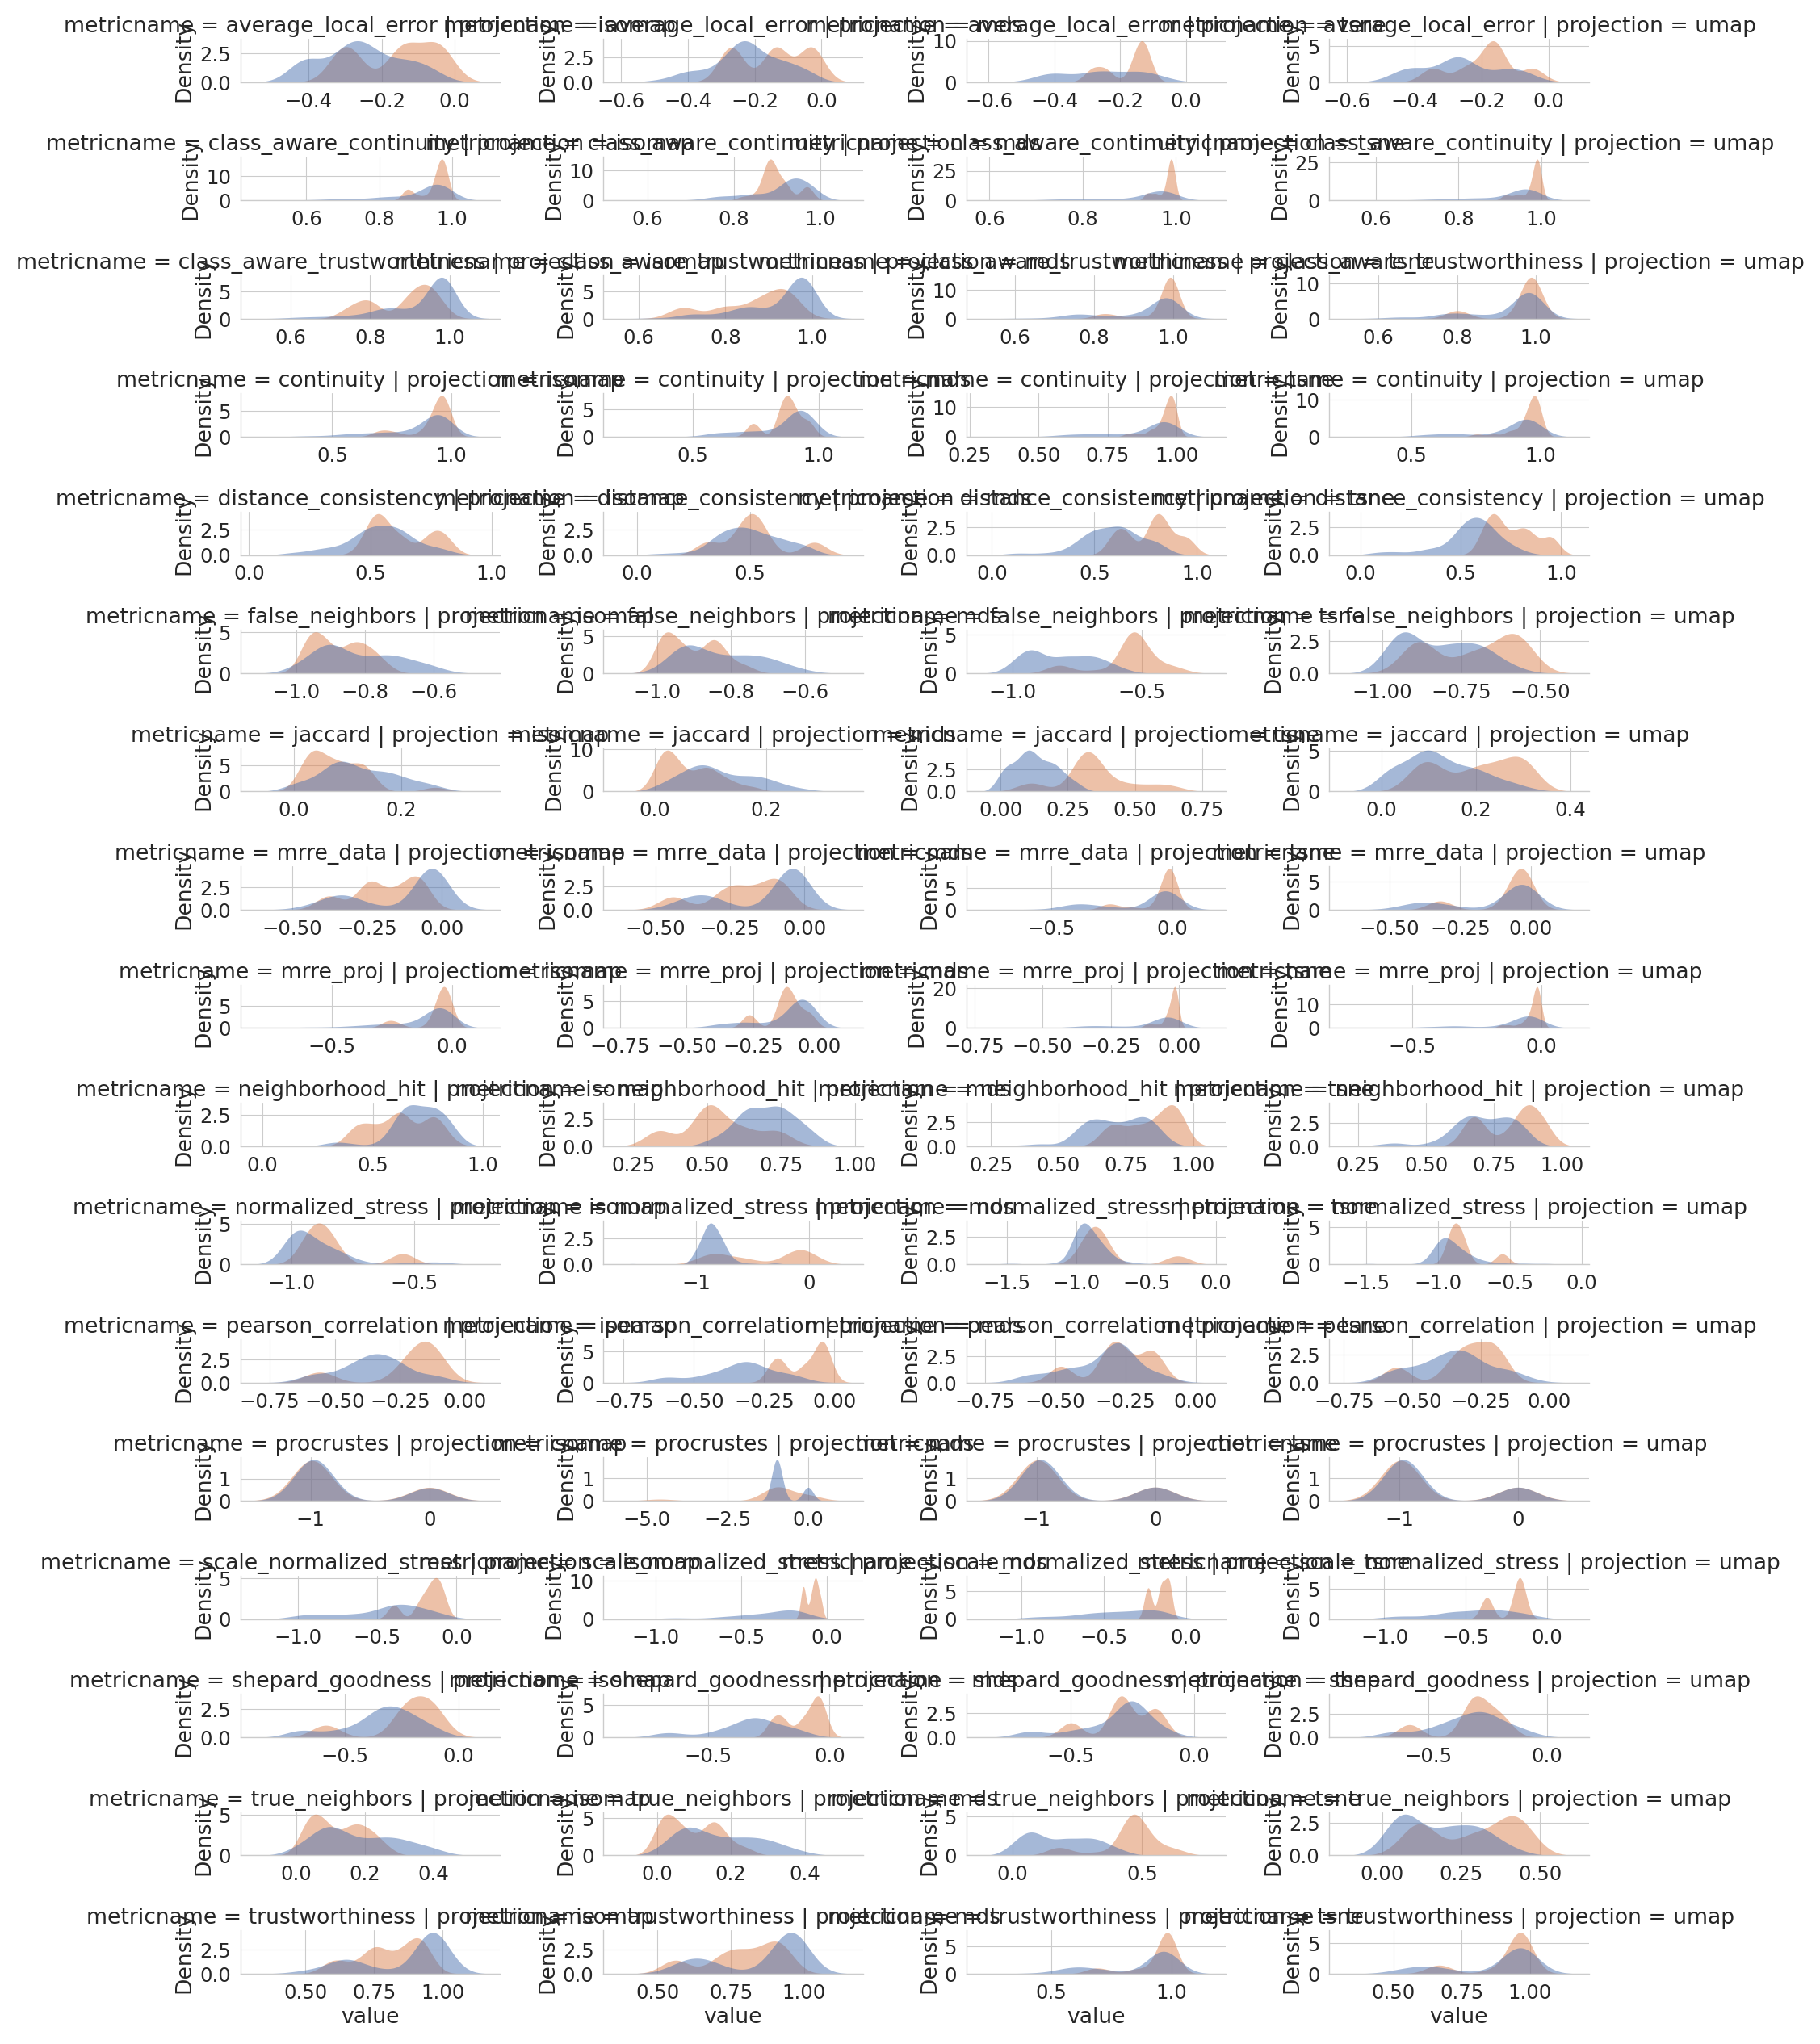

In [53]:
g = sns.FacetGrid(
    pre_and_post_fooling.melt(
        id_vars=["Kind", "projection"], value_vars=METRIC_COLNAMES, var_name="metricname"
    ),
    col="projection",
    col_order=["isomap", "mds", "tsne", "umap"],
    row="metricname",
    aspect=3.0,
    height=1.5,
    sharey=False,
    sharex=False,
    # xlim=(0.0, 1.0),
    despine=True,
    legend_out=True,
)
g.map_dataframe(
    sns.kdeplot,
    x="value",
    hue="Kind",
    fill=True,
    alpha=0.5,
    clip_on=True,
    common_norm=False,
    bw_adjust=1,
    edgecolor="w",
    lw=0,
    legend=True,
)
g.add_legend()


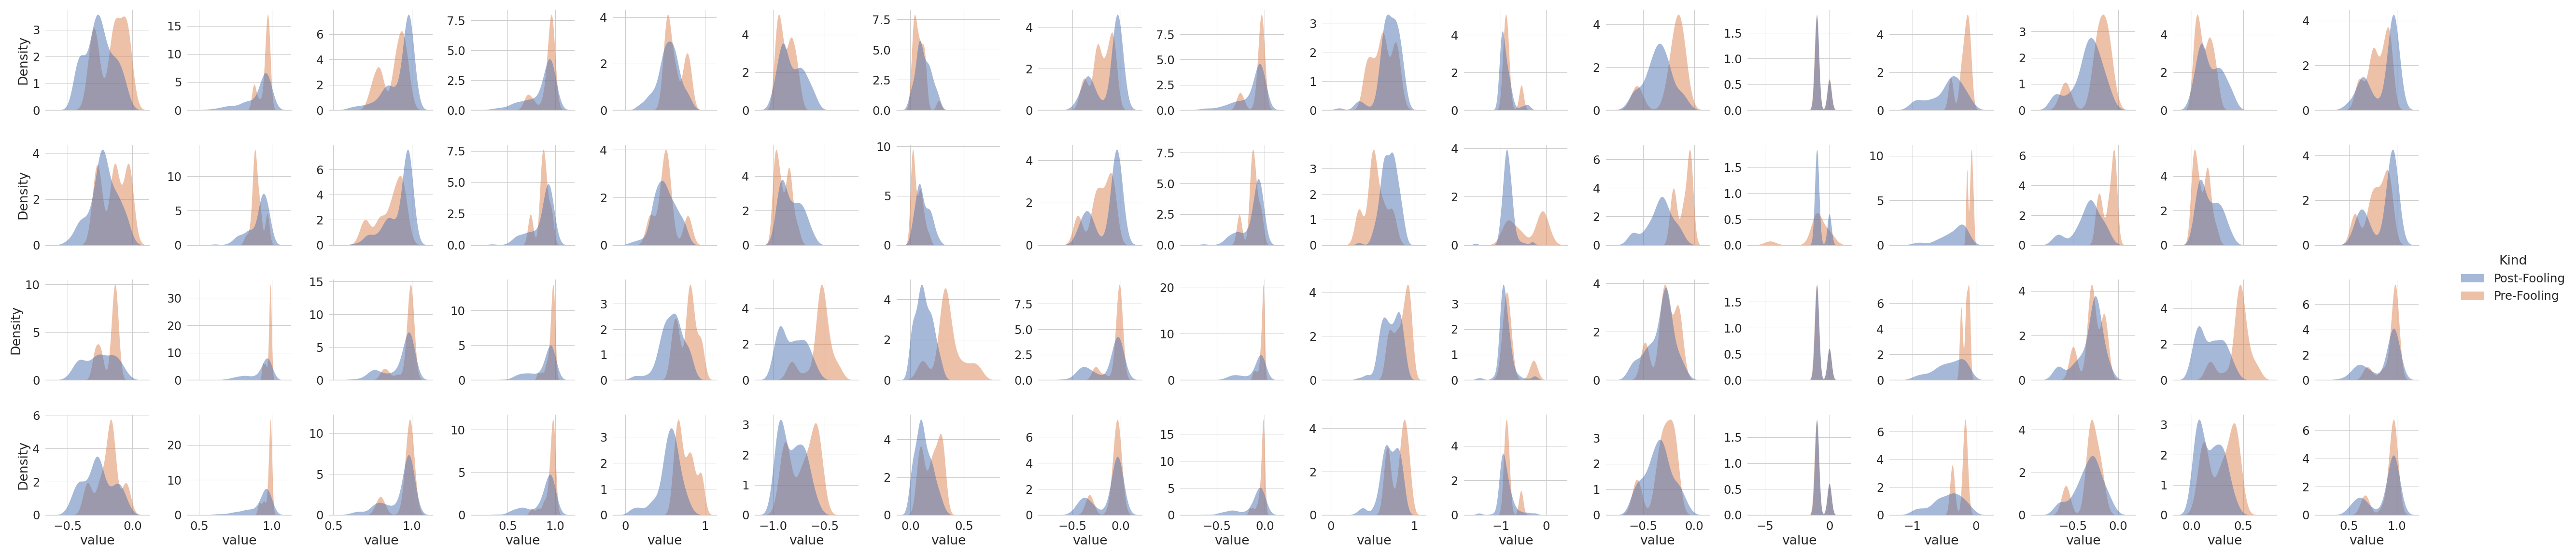

In [58]:
g = sns.displot(
    pre_and_post_fooling.melt(
        id_vars=["Kind", "projection"], value_vars=METRIC_COLNAMES, var_name="metricname"
    ),
    x="value",
    hue="Kind",
    label='Kind',
    legend=True,
    row="projection",
    col="metricname",
    row_order=["isomap", "mds", "tsne", "umap"],
    aspect=1.0,
    height=3.0,
    facet_kws=dict(sharex="col", sharey=False),
    kind="kde",
    fill=True,
    alpha=0.5,
    clip_on=True,
    common_norm=False,
    bw_adjust=1,
    edgecolor="w",
    lw=0,
)
# g.figure.legend().set_in_layout(True)
g.despine(left=True)
g.set_titles("", col_template="{col_name}", row_template="{row_name}")


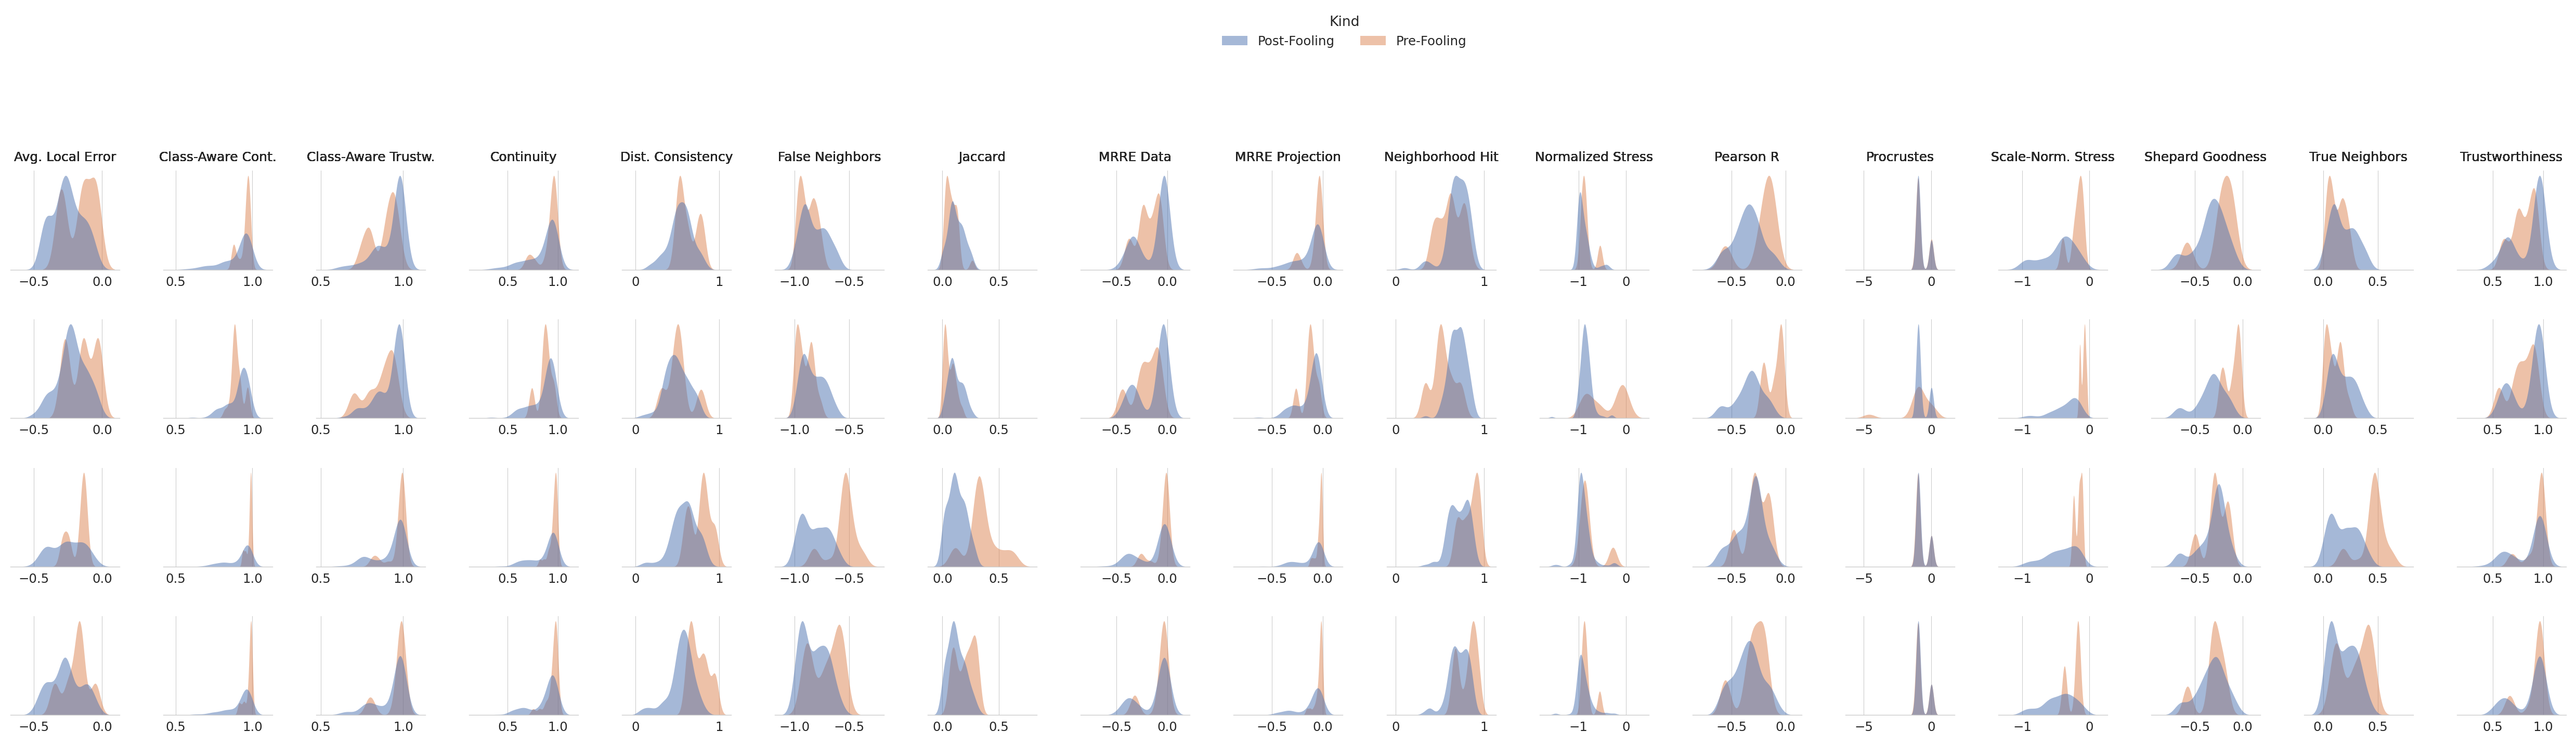

In [64]:
sns.move_legend(g.figure, loc='upper center', ncols=2, bbox_to_anchor=(0.0, 1.2, 1.0, 0.02))
g.set(yticks=[], ylabel="", xlabel="")
g.figure.subplots_adjust(hspace=0.5, wspace=0.4)
for ax, col_name in zip(g.axes[0, :], g.col_names):
    ax.annotate(
        NICE_METRIC_NAMES[col_name],
        xy=(0.5, 1.1),
        xycoords="axes fraction",
        rotation=0.0,
        va="baseline",
        ha="center",
        fontsize=18,
    )
for ax in g.axes.flat:
    ax.xaxis.set_tick_params(which='both', labelbottom=True)
g.figure